In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.io import fits
from scipy.ndimage import zoom
# import imageio as io
import PIL

In [2]:
def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = np.linspace(-c, c, size, endpoint=False)
    Xs, Ys = np.meshgrid(xs, xs)
    Rs = np.hypot(Xs, Ys)
    
    if radius is None:
        aperture = np.where(Rs > c, 0, np.ones([size, size]))
    else:
        aperture = np.where(Rs > radius, 0, np.ones([size, size]))
    return aperture

def get_toliman_pupil(size, path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = np.load("Toliman_pupil.npy")
    else:
        toliman_pupil = np.load("{}/Toliman_pupil.npy".format(path))
        
    phase = np.angle(toliman_pupil)
    magnitude = np.abs(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = magnitude * np.exp(1j * phase_scaled)
    return toliman_pupil_out
def phase_to_depth(comp_array, wl, n1, n2):
    """
    Converts a phase value (0, pi) to a depth for a specified wavelength
    """
    depth_array = (np.angle(comp_array) * wl) / (2 * np.pi * (n2 - n1))
    return depth_array

def generate_sinusoids(size, N, period, ampl):
    # Create meshgrid for sinusoids
    Xs = np.linspace(0, size, num=N, endpoint=False)
    X, Y = np.meshgrid(Xs, Xs)

    # Define the sine argument value to get the correct period
    B = 2*np.pi / period

    # Creating gratings
    grating = (ampl*np.sin(B*Y) + ampl*np.sin(B*X))/4
    anti_grating = (ampl*np.sin(B*Y + np.pi) + ampl*np.sin(B*X + np.pi))/4
    
    # Note here we divide the output by 4: 
    # ampl is a peak to trough value so we must halve the output once
    # To get orthogonal sine waves we sum two seperate 1D sine patterns
    # so the amplitude is doubled so we must halve again
    
    return grating, anti_grating, X, Y

---
### Define Physics paramters

In [3]:
# pupil (pattern) diameter
diameter = 20e-3 # 20mm

# Desired pattern resolution
# resolution_in = 25e-6 # 25um
resolution_in = 10e-6 # 10um

# Calcualte number of pixels
N = np.round(diameter/resolution_in, decimals=0).astype(np.int)
resolution = diameter/N
print("True resolution is {}um".format(resolution*1e6))
print("Pattern requires {} pixels".format(N))

# Sinusoidal grating paramters
grating_amplitude = 100e-9 # 100nm
grating_period = 100e-6 # 100 microns

# Substrate and observatioanl properties
# Target wavelength where we get perfect antiphase
wl = 635e-9 # 635nm
n1 = 1 # unitless
n2 = 1.455 # unitless

True resolution is 10.0um
Pattern requires 2000 pixels


In [4]:
# Import pupil
pupil = get_toliman_pupil(N)

# Create masks to apply gratings
norm_phase = np.angle(pupil) == 0
anti_phase = np.angle(pupil) == np.pi

# Turn pupil into array of physical depth values
pupil_physical = phase_to_depth(pupil, wl, n1, n2)

# Get pupil support
magnitude = get_aperture(N)

# Generate sinusoidal grating
grating, anti_grating, X, Y = generate_sinusoids(diameter, N, grating_period, grating_amplitude)

In [5]:
# Combine these values into final pupil and normalise
Zraw = magnitude * (norm_phase*(pupil_physical + grating) + anti_phase*(pupil_physical + anti_grating))
Zshift = Zraw - np.min(Zraw)
Znorm = Zshift/np.max(Zshift)

# 16 bit out
Zout = ((2**16 - 1)*Znorm).astype(np.uint16)

# 8 bit out
# Zout = ((2**8 - 1)*Znorm).astype(np.uint8)

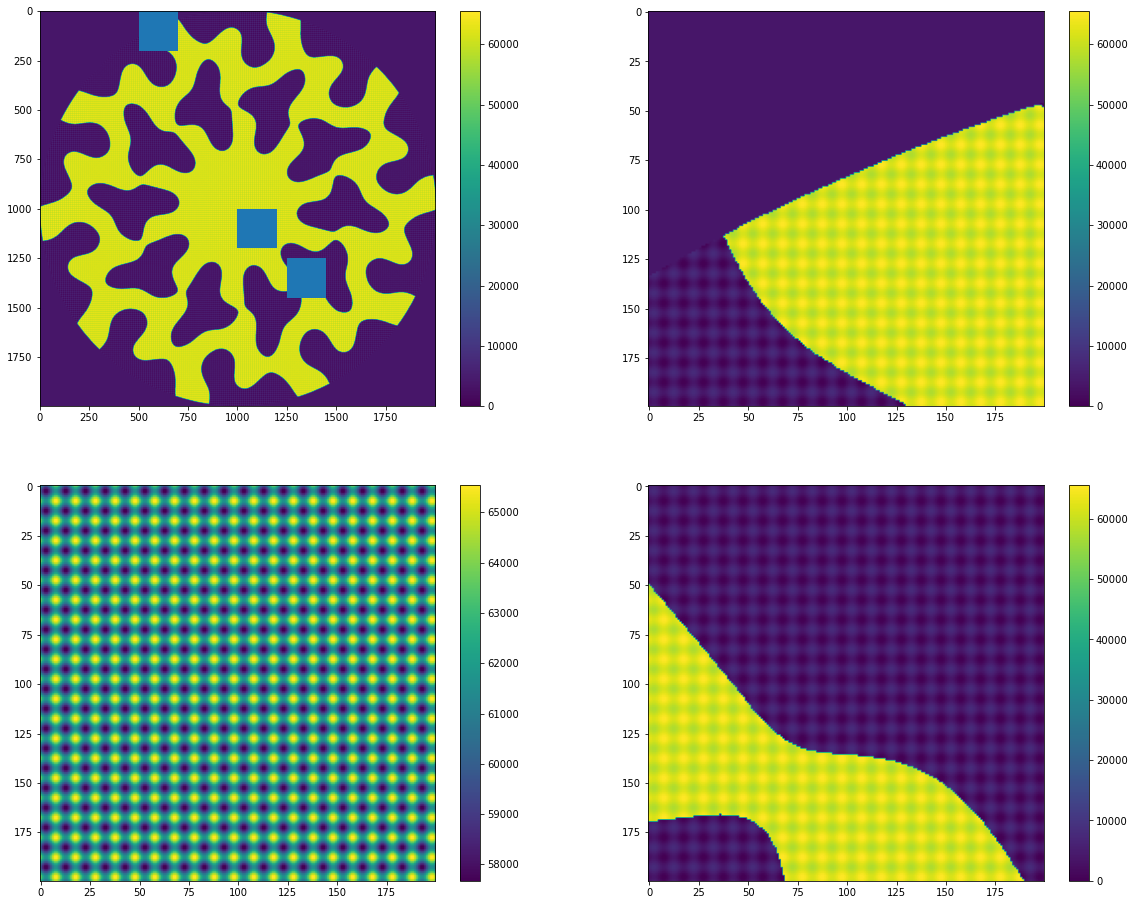

In [6]:
# Check that Z is what we expect
ratio = N / 800 #  / N
size = int(ratio * 80)

x1 = int(200 * ratio)
y1 = int(0 * ratio)
cut_1 = Zout[y1:y1+size, x1:x1+size]

x2 = int(400 * ratio)
y2 = int(400 * ratio)
cut_2 = Zout[y2:y2+size, x2:x2+size]

x3 = int(500 * ratio)
y3 = int(500 * ratio)
cut_3 = Zout[y3:y3+size, x3:x3+size]

plt.figure(figsize=(20,16))

ax = plt.subplot(2,2,1)
plt.imshow(Zout)
ax.add_patch(patches.Rectangle((x1, y1), size, size))
ax.add_patch(patches.Rectangle((x2, y2), size, size))
ax.add_patch(patches.Rectangle((x3, y3), size, size))
plt.colorbar()


plt.subplot(2,2,2)
plt.imshow(cut_1)
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(cut_2)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(cut_3)
plt.colorbar()
plt.show()

---

## Save files

In [7]:
im = PIL.Image.fromarray(Zout.astype(np.uint8))
# im = PIL.Image.fromarray(Zout.astype(np.uint16))
im.save("test.bmp", format='bmp', mode="L")